# pip

In [1]:
pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip uninstall preprocessor

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


# Import module

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, SubsetRandomSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import preprocessor as p

from transformers import XLMModel, BertTokenizer, BertForSequenceClassification,  XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


from tqdm import tqdm, trange
from sklearn.model_selection import KFold
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [4]:
MAX_LEN = 256

# Load data & preprocessing

In [5]:
#long_covid
df = pd.read_csv('long_covid1003_unique.csv', encoding= 'unicode_escape')
print(f'Total shape : {df.shape}\nLabel distribution : \n\t0:{df.shape[0]-df.label.values.sum()}\n\t1:{df.label.values.sum()}')
df, val_df = train_test_split(df, test_size = 0.2, stratify = df.label, random_state = 42 )
val_df, test_df = train_test_split(val_df, test_size = 0.5, stratify = val_df.label, random_state = 42 )
print('Split shape : ',df.shape, val_df.shape, test_df.shape)

Total shape : (2927, 3)
Label distribution : 
	0:566
	1:2361
Split shape :  (2341, 3) (293, 3) (293, 3)


In [6]:
df.label.values.sum()

1888

In [7]:
#df.tweet.values

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

In [9]:
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
    text = row['tweet']
    # text = text.strip('\xa0')
    text = p.clean(text)
    tokenization = nltk.word_tokenize(text)     
    tokenization = [w for w in tokenization if not w in stop_words]
    #   text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    #   text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # text = re.sub(r'\([0-9]+\)', '', text).strip()    
    return text

In [10]:
df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
val_df['tweet'] = val_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)

In [11]:
train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label.values
val_labels = val_df.label.values
test_labels = test_df.label.values
#print(train_sentences)

# Bert

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [14]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [15]:
print('Train token ids:\n',train_token_ids[0])
print('Train attention masks:\n', train_attention_masks[0])

Train token ids:
 tensor([  101,  2017,  2128, 11311,  2000,  1996, 21887,  7865,  2065,  2017,
         3344,  2105,  1037, 25234, 26536,  1997,  2300,  2000,  4392,  2076,
         1996,  2154,  1999,  2690,  2082,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

In [16]:
batch_size = 64

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [17]:
#load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).cuda()
epochs = 20
#setting parameters of optimizer
param_optimizer = list(model.named_parameters())
#weight decay to avoid overfitting (linear transformation / self-attention)
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#load optimizer
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
total = [param.nelement() for param in model.parameters()]
print(f"Number of parameter:{sum(total)}\n and each layer is:{total}")

Number of parameter:109483778
 and each layer is:[23440896, 393216, 1536, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824,

In [24]:
#learning rate scheduler(decay)
# 指數下降
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# # warm up 
# # 總訓練步數是批次數乘以Epoch數
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = total_steps*0.2, # 預熱步數，也可以設定為總步數的一部分，如total_steps*0.1
#                                             num_training_steps = total_steps)


In [18]:
#define accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#define precision_Score
def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

#define recall_Score
def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)

#define f1_Score
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

#define roc_auc
def flat_roc_auc(preds, labels):
    labels_flat = labels.flatten()
    fpr, tpr, thresholds = roc_curve(labels_flat, preds)
    roc_auc = auc(fpr, tpr)
    return roc_auc
    #return roc_auc_score(labels_flat, pred_probs)
#Confusion matrix
def plot_confusion_matrix(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, pred_flat)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [19]:
#prepare clean sets to store performance of each epoches
train_loss_set = []
val_loss_set = []
train_acc_set = []
val_acc_set = []
val_f1_set = []
val_auc_set = []
best_val_f1_score = 0.90
directory_path = ''


#training
for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss, train_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1].cpu().detach().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_tr_steps += 1
        
# learning rate scheduler        
    #     # warm up 
    #     scheduler.step()
    # after_lr = optimizer.param_groups[0]["lr"] 
    
# #     # Exponential    
#     before_lr = optimizer.param_groups[0]["lr"]
#     scheduler.step()
#     after_lr = optimizer.param_groups[0]["lr"]
    
#     print("Epoch %d: AdamW lr %.6f -> %.6f" % (_, before_lr, after_lr))
    
    train_acc_set.append(train_accuracy/nb_tr_steps)
    train_loss_set.append(tr_loss/nb_tr_steps)
    #print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
#evaluation
    model.eval()

    val_loss, eval_accuracy, eval_f1_score, eval_roc_auc = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        #move outputs to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #append loss and calculate accuracy
        val_loss += loss.item()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)   
        
        #calculate f1
        tmp_f1 = flat_f1(logits, label_ids)
        
        #calculate auc_roc_score
        probs = softmax(logits)[:,1]
        tmp_roc_auc = flat_roc_auc(probs, label_ids)
        
        #summarize metrics from each batch
        eval_accuracy += tmp_eval_accuracy
        eval_f1_score += tmp_f1
        eval_roc_auc += tmp_roc_auc
        nb_eval_steps += 1

    val_acc_set.append(eval_accuracy/nb_eval_steps)
    val_loss_set.append(val_loss/nb_eval_steps)
    val_f1_set.append(eval_f1_score/nb_eval_steps)
    val_auc_set.append(eval_roc_auc/nb_eval_steps)
    print("Validation loss: {}".format(val_loss/nb_tr_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("Validation F1_score: {}".format(eval_f1_score/nb_eval_steps))
    print("Validation AUC: {}".format(eval_roc_auc/nb_eval_steps))
    Validation_F1_score = (eval_f1_score/nb_eval_steps)
    if(Validation_F1_score >= best_val_f1_score):
        torch.save(model.state_dict(), 'BERT_base_uncased_best_model.ckpt')
        best_val_f1_score = Validation_F1_score
        print('Model Saved')

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.03901184007928178
Validation Accuracy: 0.9002533783783784
Validation F1_score: 0.9405537030537031
Validation AUC: 0.9327056196621413


Epoch:   5%|▌         | 1/20 [00:15<04:59, 15.77s/it]

Model Saved
Validation loss: 0.028589572254064922
Validation Accuracy: 0.9298141891891891
Validation F1_score: 0.9574081821039145
Validation AUC: 0.9537980739067695


Epoch:  10%|█         | 2/20 [00:31<04:45, 15.83s/it]

Model Saved


Epoch:  15%|█▌        | 3/20 [00:47<04:27, 15.75s/it]

Validation loss: 0.02399088381915479
Validation Accuracy: 0.9266891891891891
Validation F1_score: 0.9551285943614456
Validation AUC: 0.962428006775833
Validation loss: 0.0290967457600542
Validation Accuracy: 0.9360641891891891
Validation F1_score: 0.9610445457402783
Validation AUC: 0.9569031894031894


Epoch:  20%|██        | 4/20 [01:03<04:14, 15.93s/it]

Model Saved


Epoch:  25%|██▌       | 5/20 [01:19<03:58, 15.90s/it]

Validation loss: 0.030219911723523528
Validation Accuracy: 0.9235641891891891
Validation F1_score: 0.9523812149618601
Validation AUC: 0.9602395752395753


Epoch:  30%|███       | 6/20 [01:35<03:42, 15.92s/it]

Validation loss: 0.03795374748674599
Validation Accuracy: 0.9289695945945946
Validation F1_score: 0.9559038732386169
Validation AUC: 0.9553011682359509
Validation loss: 0.03569601194278614
Validation Accuracy: 0.9383445945945945
Validation F1_score: 0.9618168834809955
Validation AUC: 0.9539724245159029


Epoch:  35%|███▌      | 7/20 [01:51<03:29, 16.10s/it]

Model Saved


Epoch:  40%|████      | 8/20 [02:07<03:12, 16.08s/it]

Validation loss: 0.04308277851826436
Validation Accuracy: 0.9352195945945946
Validation F1_score: 0.9600487433642316
Validation AUC: 0.9550717036586602


Epoch:  45%|████▌     | 9/20 [02:23<02:56, 16.08s/it]

Validation loss: 0.04887426141146067
Validation Accuracy: 0.9320945945945945
Validation F1_score: 0.9578066934900609
Validation AUC: 0.9535545452936759


Epoch:  50%|█████     | 10/20 [02:39<02:40, 16.06s/it]

Validation loss: 0.052133887200742156
Validation Accuracy: 0.9352195945945946
Validation F1_score: 0.9600487433642316
Validation AUC: 0.954391735478692


Epoch:  55%|█████▌    | 11/20 [02:55<02:24, 16.05s/it]

Validation loss: 0.054485008120536804
Validation Accuracy: 0.9266891891891891
Validation F1_score: 0.9537941285767373
Validation AUC: 0.9556646292515858


Epoch:  60%|██████    | 12/20 [03:11<02:08, 16.04s/it]

Validation loss: 0.053975594204825325
Validation Accuracy: 0.9329391891891892
Validation F1_score: 0.957987738917008
Validation AUC: 0.9545905744818789


Epoch:  65%|██████▌   | 13/20 [03:27<01:52, 16.03s/it]

Validation loss: 0.05550457617721042
Validation Accuracy: 0.9329391891891892
Validation F1_score: 0.957987738917008
Validation AUC: 0.9537217211130254


Epoch:  70%|███████   | 14/20 [03:43<01:36, 16.02s/it]

Validation loss: 0.05673804718094903
Validation Accuracy: 0.9329391891891892
Validation F1_score: 0.957987738917008
Validation AUC: 0.9529136403049447


Epoch:  75%|███████▌  | 15/20 [03:59<01:20, 16.02s/it]

Validation loss: 0.05783311378311466
Validation Accuracy: 0.9329391891891892
Validation F1_score: 0.957987738917008
Validation AUC: 0.9521890870803915


Epoch:  80%|████████  | 16/20 [04:15<01:04, 16.01s/it]

Validation loss: 0.05900175748644648
Validation Accuracy: 0.9298141891891891
Validation F1_score: 0.9560839659851975
Validation AUC: 0.9521890870803915


Epoch:  85%|████████▌ | 17/20 [04:31<00:48, 16.01s/it]

Validation loss: 0.05884077178465354
Validation Accuracy: 0.9320945945945945
Validation F1_score: 0.9577038040105101
Validation AUC: 0.9505139104052148


Epoch:  90%|█████████ | 18/20 [04:47<00:32, 16.00s/it]

Validation loss: 0.06121068548511814
Validation Accuracy: 0.9235641891891891
Validation F1_score: 0.9517835465661552
Validation AUC: 0.9539207290294247


Epoch:  95%|█████████▌| 19/20 [05:03<00:16, 16.00s/it]

Validation loss: 0.06202356920048997
Validation Accuracy: 0.9266891891891891
Validation F1_score: 0.9540743366549818
Validation AUC: 0.9522637467202685


Epoch: 100%|██████████| 20/20 [05:19<00:00, 16.00s/it]

Validation loss: 0.06499312173675846
Validation Accuracy: 0.9204391891891891
Validation F1_score: 0.9496924337954308
Validation AUC: 0.9510102216623956


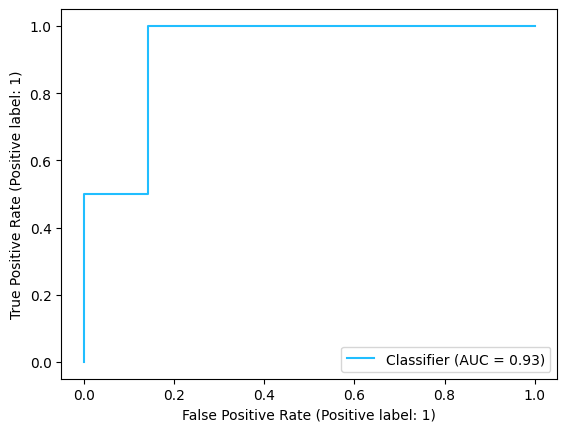

In [20]:
RocCurveDisplay.from_predictions(label_ids.flatten(), probs, color='#20BEFF')

# XLNet

In [12]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

In [13]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [14]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [15]:
batch_size = 64

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [8]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [9]:
total = [param.nelement() for param in model.parameters()]
print(f"Number of parameter:{sum(total)}\n and each layer is:{total}")

Number of parameter:117310466
 and each layer is:[768, 24576000, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 1536, 768, 768, 768, 768, 2359296, 3072, 2359296, 768, 589824, 589824, 589824, 589824, 589824, 768, 768, 768, 

In [16]:
#learning rate scheduler(decay)
# 指數下降
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# decayRate = 0.96
# # warm up 
# # 總訓練步數是批次數乘以Epoch數
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = total_steps*0.2, # 預熱步數，也可以設定為總步數的一部分，如total_steps*0.1
#                                             num_training_steps = total_steps)

In [32]:
#define accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#define precision_Score
def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

#define recall_Score
def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)

#define f1_Score
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

#define roc_auc
def flat_roc_auc(preds, labels):
    labels_flat = labels.flatten()
    fpr, tpr, thresholds = roc_curve(labels_flat, preds)
    roc_auc = auc(fpr, tpr)
    return roc_auc
    #return roc_auc_score(labels_flat, pred_probs)
#Confusion matrix
def plot_confusion_matrix(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, pred_flat)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [50]:
#prepare clean sets to store performance of each epoches
epochs = 20
train_loss_set = []
val_loss_set = []
train_acc_set = []
val_acc_set = []
val_f1_set = []
val_auc_set = []
best_val_f1_score = 0.90
directory_path = ''


#training
for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss, train_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1].cpu().detach().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        loss.backward()
        optimizer.step()
        
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_tr_steps += 1
        
# learning rate scheduler        
    #     # warm up 
    #     scheduler.step()
    # after_lr = optimizer.param_groups[0]["lr"] 
    
# #     # Exponential    
#     before_lr = optimizer.param_groups[0]["lr"]
#     scheduler.step()
#     after_lr = optimizer.param_groups[0]["lr"]
    
#     print("Epoch %d: AdamW lr %.6f -> %.6f" % (_, before_lr, after_lr))
    
    train_acc_set.append(train_accuracy/nb_tr_steps)
    train_loss_set.append(tr_loss/nb_tr_steps)
    #print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
#evaluation
    model.eval()

    val_loss, eval_accuracy, eval_f1_score, eval_roc_auc = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        #move outputs to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #append loss and calculate accuracy
        val_loss += loss.item()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)   
        
        #calculate f1
        tmp_f1 = flat_f1(logits, label_ids)
        
        #calculate auc_roc_score
        probs = softmax(logits)[:,1]
        tmp_roc_auc = flat_roc_auc(probs, label_ids)
        
        #summarize metrics from each batch
        eval_accuracy += tmp_eval_accuracy
        eval_f1_score += tmp_f1
        eval_roc_auc += tmp_roc_auc
        nb_eval_steps += 1

    val_acc_set.append(eval_accuracy/nb_eval_steps)
    val_loss_set.append(val_loss/nb_eval_steps)
    val_f1_set.append(eval_f1_score/nb_eval_steps)
    val_auc_set.append(eval_roc_auc/nb_eval_steps)
    print("Validation loss: {}".format(val_loss/nb_tr_steps))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("Validation F1_score: {}".format(eval_f1_score/nb_eval_steps))
    print("Validation AUC: {}".format(eval_roc_auc/nb_eval_steps))
    Validation_F1_score = (eval_f1_score/nb_eval_steps)
    if(Validation_F1_score >= best_val_f1_score):
        torch.save(model.state_dict(), 'XLNET_base_best_model.ckpt')
        best_val_f1_score = Validation_F1_score
        print('Model Saved')

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation loss: 0.027508145248567737
Validation Accuracy: 0.9158783783783784
Validation F1_score: 0.9468121024556668
Validation AUC: 0.9552513589470111


Epoch:   5%|▌         | 1/20 [00:33<10:37, 33.55s/it]

Model Saved
Validation loss: 0.02233810742964616
Validation Accuracy: 0.9360641891891891
Validation F1_score: 0.9610436440880005
Validation AUC: 0.9680231242187765


Epoch:  10%|█         | 2/20 [01:07<10:06, 33.70s/it]

Model Saved


Epoch:  15%|█▌        | 3/20 [01:40<09:31, 33.64s/it]

Validation loss: 0.023726552724838257
Validation Accuracy: 0.9360641891891891
Validation F1_score: 0.9601118236602109
Validation AUC: 0.9699325674325674


Epoch:  20%|██        | 4/20 [02:14<08:58, 33.65s/it]

Validation loss: 0.027802118024713284
Validation Accuracy: 0.9383445945945945
Validation F1_score: 0.9608717140499895
Validation AUC: 0.9689345075214642


Epoch:  25%|██▌       | 5/20 [02:48<08:25, 33.69s/it]

Validation loss: 0.034107456134783255
Validation Accuracy: 0.9195945945945946
Validation F1_score: 0.9485616428845394
Validation AUC: 0.96762032653337
Validation loss: 0.030520985154686747
Validation Accuracy: 0.9445945945945946
Validation F1_score: 0.9648655031927801
Validation AUC: 0.9652324366454803


Epoch:  30%|███       | 6/20 [03:22<07:54, 33.88s/it]

Model Saved


Epoch:  35%|███▌      | 7/20 [03:56<07:20, 33.87s/it]

Validation loss: 0.038975583188034395
Validation Accuracy: 0.9320945945945945
Validation F1_score: 0.9570303704186875
Validation AUC: 0.9704817404817405


Epoch:  40%|████      | 8/20 [04:30<06:46, 33.86s/it]

Validation loss: 0.02874739415238838
Validation Accuracy: 0.9414695945945946
Validation F1_score: 0.9629311498505517
Validation AUC: 0.9750130907739603


Epoch:  45%|████▌     | 9/20 [05:04<06:12, 33.86s/it]

Validation loss: 0.03717708124502285
Validation Accuracy: 0.9289695945945946
Validation F1_score: 0.954834042476865
Validation AUC: 0.9716292041292041


Epoch:  50%|█████     | 10/20 [05:38<05:38, 33.87s/it]

Validation loss: 0.04293109203462262
Validation Accuracy: 0.9423141891891891
Validation F1_score: 0.9642022169350227
Validation AUC: 0.9642954871215741


Epoch:  55%|█████▌    | 11/20 [06:11<05:04, 33.84s/it]

Validation loss: 0.05555130692349898
Validation Accuracy: 0.9110641891891891
Validation F1_score: 0.9428405480472442
Validation AUC: 0.9646567080262732


Epoch:  60%|██████    | 12/20 [06:45<04:30, 33.82s/it]

Validation loss: 0.04940435723275752
Validation Accuracy: 0.9391891891891891
Validation F1_score: 0.9627031413855338
Validation AUC: 0.9658510450901755
Validation loss: 0.04668396632061214
Validation Accuracy: 0.9445945945945946
Validation F1_score: 0.9649512890257759
Validation AUC: 0.9671191369017457


Epoch:  65%|██████▌   | 13/20 [07:19<03:57, 33.93s/it]

Model Saved


Epoch:  70%|███████   | 14/20 [07:53<03:23, 33.88s/it]

Validation loss: 0.057055727452845185
Validation Accuracy: 0.9173141891891892
Validation F1_score: 0.9472921754983478
Validation AUC: 0.9675537023363111


Epoch:  75%|███████▌  | 15/20 [08:27<02:49, 33.85s/it]

Validation loss: 0.039135282506813876
Validation Accuracy: 0.9320945945945945
Validation F1_score: 0.9570657559869792
Validation AUC: 0.9719358298706124


Epoch:  80%|████████  | 16/20 [09:01<02:15, 33.82s/it]

Validation loss: 0.03479406873166964
Validation Accuracy: 0.9423141891891891
Validation F1_score: 0.9639845101135422
Validation AUC: 0.9723398220137351


Epoch:  85%|████████▌ | 17/20 [09:34<01:41, 33.81s/it]

Validation loss: 0.06140979762012894
Validation Accuracy: 0.9150337837837839
Validation F1_score: 0.9446752324027287
Validation AUC: 0.9720236647410561


Epoch:  90%|█████████ | 18/20 [10:08<01:07, 33.79s/it]

Validation loss: 0.04899356353121835
Validation Accuracy: 0.9235641891891891
Validation F1_score: 0.9505775903987859
Validation AUC: 0.9766919553876076


Epoch:  95%|█████████▌| 19/20 [10:42<00:33, 33.77s/it]

Validation loss: 0.04222502568862527
Validation Accuracy: 0.9391891891891891
Validation F1_score: 0.9621953922655185
Validation AUC: 0.971038406038406


Epoch: 100%|██████████| 20/20 [11:16<00:00, 33.81s/it]

Validation loss: 0.04408585320453386
Validation Accuracy: 0.9352195945945946
Validation F1_score: 0.9585216880897803
Validation AUC: 0.9750376917768222


# Visualization

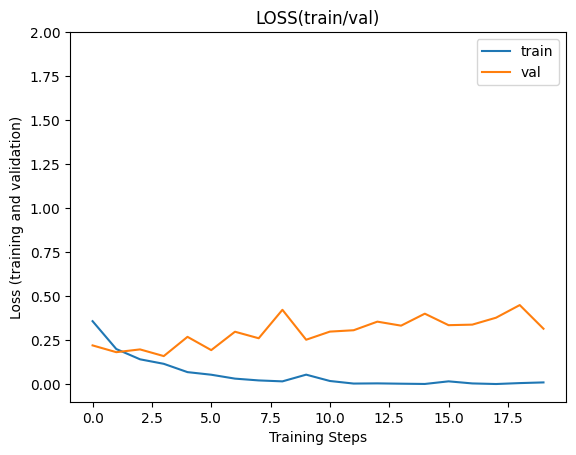

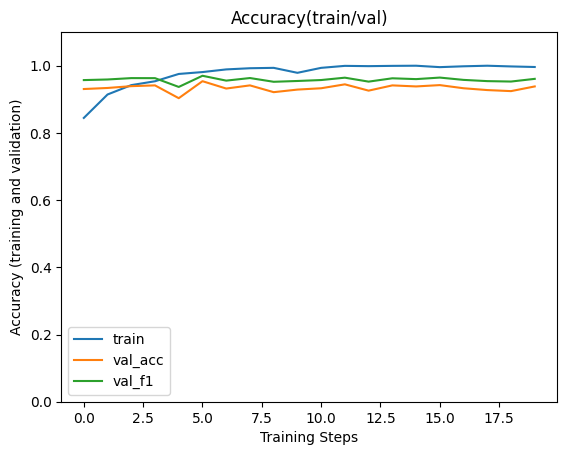

In [28]:
# Visualize training process

plt.figure('LOSS(train/val)')
plt.title('LOSS(train/val)')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([-0.1,2])
plt.plot(train_loss_set, label = 'train')
plt.plot(val_loss_set, label = 'val')
plt.legend()

plt.figure('Accuracy(train/val)')
plt.title('Accuracy(train/val)')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(train_acc_set, label = 'train')
plt.plot(val_acc_set, label = 'val_acc')
plt.plot(val_f1_set, label = 'val_f1')
plt.legend()

# Evaluation

In [ ]:
# 載入Bert模型
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.load_state_dict(torch.load('BERT_base_uncased_best_model.ckpt'))
model.to(device)
model.eval()

# 預測
preds = []
labels_list = []
probs_list = []  # 用於存儲正類概率

for batch in test_dataloader:
    input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds_batch = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        # 從logits取得正類的概率
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pos_probs_batch = probs[:, 1].cpu().numpy()
        
    preds.append(preds_batch)
    labels_list.append(labels_batch.cpu().numpy())
    probs_list.append(pos_probs_batch)

preds = np.concatenate(preds)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(probs_list)

# 計算準確度
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
# 使用正類的概率計算AUC
test_auc = roc_auc_score(labels, pos_probs)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


In [ ]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [25]:
BERT_ACC = [93.06, 94.01, 93.38, 91.48, 92.74]
BERT_PRE = [96.14, 96.98, 94.63, 93.39, 95.34]
BERT_REC = [94.51, 94.94, 96.62, 95.36, 94.94]
BERT_F1  = [95.32, 95.95, 95.62, 94.36, 95.14]
BERT_AUC = [97.54, 97.31, 97.33, 96.15, 96.61]
BERT_TIME = [330, 348, 345, 346, 346]

print(f'acc:{sum(BERT_ACC)/5:.2f}, std:{np.std(BERT_ACC):.2f}')
print(f'precision:{sum(BERT_PRE)/5:.2f}, std:{np.std(BERT_PRE):.2f}')
print(f'recall:{sum(BERT_REC)/5:.2f}, std:{np.std(BERT_REC):.2f}')
print(f'f1:{sum(BERT_F1)/5:.2f}, std:{np.std(BERT_F1):.2f}')
print(f'auc:{sum(BERT_AUC)/5:.2f}, std:{np.std(BERT_AUC):.2f}')
print(f'time:{sum(BERT_TIME)/5:.2f}, std:{np.std(BERT_TIME):.2f}')

acc:92.93, std:0.84
precision:95.30, std:1.24
recall:95.27, std:0.72
f1:95.28, std:0.54
auc:96.99, std:0.52
time:343.00, std:6.57


In [ ]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

In [16]:
# 載入XLNet模型
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))
model.to(device)
model.eval()

# 預測
preds = []
labels_list = []
probs_list = []  # 用於存儲正類概率

for batch in test_dataloader:
    input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds_batch = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        # 從logits取得正類的概率
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pos_probs_batch = probs[:, 1].cpu().numpy()
        
    preds.append(preds_batch)
    labels_list.append(labels_batch.cpu().numpy())
    probs_list.append(pos_probs_batch)

preds = np.concatenate(preds)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(probs_list)

# 計算準確度
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
# 使用正類的概率計算AUC
test_auc = roc_auc_score(labels, pos_probs)

print(f"XLNet Test Accuracy: {accuracy * 100:.2f}%")
print(f"XLNet Test Precision: {precision * 100:.2f}%")
print(f"XLNet Test Recall: {recall * 100:.2f}%")
print(f"XLNet Test F1-score: {f1 * 100:.2f}%")
print(f"XLNet Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNet Test Accuracy: 92.83%
XLNet Test Precision: 94.24%
XLNet Test Recall: 97.03%
XLNet Test F1-score: 95.62%
XLNet Test AUC: 96.12%


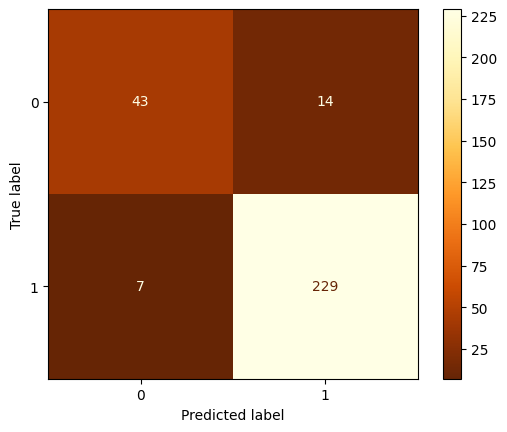

In [17]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [ ]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

In [27]:
XLNet_ACC = [93.06, 93.06, 94.32, 93.69, 92.74]
XLNet_PRE = [92.83, 95.36, 94.69, 93.93, 96.52]
XLNet_REC = [98.31, 95.36, 97.89, 97.89, 93.67]
XLNet_F1  = [95.49, 95.36, 96.27, 97.89, 95.07]
XLNet_AUC = [97.99, 98.13, 98.25, 98.22, 97.90]
XLNet_TIME = [741, 733, 736, 732, 732]

print(f'acc:{sum(XLNet_ACC)/5:.2f}, std:{np.std(XLNet_ACC):.2f}')
print(f'precision:{sum(XLNet_PRE)/5:.2f}, std:{np.std(XLNet_PRE):.2f}')
print(f'recall:{sum(XLNet_REC)/5:.2f}, std:{np.std(XLNet_REC):.2f}')
print(f'f1:{sum(XLNet_F1)/5:.2f}, std:{np.std(XLNet_F1):.2f}')
print(f'auc:{sum(XLNet_AUC)/5:.2f}, std:{np.std(XLNet_AUC):.2f}')
print(f'time:{sum(XLNet_TIME)/5:.2f}, std:{np.std(XLNet_TIME):.2f}')

acc:93.37, std:0.56
precision:94.67, std:1.25
recall:96.62, std:1.81
f1:96.02, std:1.02
auc:98.10, std:0.13
time:734.80, std:3.43


In [ ]:
XLNet_ACC = [93.06, 93.06, 94.32, 93.69, 92.74]
XLNet_PRE = [92.83, 95.36, 94.69, 93.93, 96.52]
XLNet_REC = [98.31, 95.36, 97.89, 97.89, 93.67]
XLNet_F1  = [95.49, 95.36, 96.27, 97.89, 95.07]
XLNet_AUC = [97.99, 98.13, 98.25, 98.22, 97.90]
XLNet_TIME = [741, 733, 736, 732, 732]

print(f'acc:{sum(XLNet_ACC)/5:.2f}, std:{np.std(XLNet_ACC):.2f}')
print(f'precision:{sum(XLNet_PRE)/5:.2f}, std:{np.std(XLNet_PRE):.2f}')
print(f'recall:{sum(XLNet_REC)/5:.2f}, std:{np.std(XLNet_REC):.2f}')
print(f'f1:{sum(XLNet_F1)/5:.2f}, std:{np.std(XLNet_F1):.2f}')
print(f'auc:{sum(XLNet_AUC)/5:.2f}, std:{np.std(XLNet_AUC):.2f}')
print(f'time:{sum(XLNet_TIME)/5:.2f}, std:{np.std(XLNet_TIME):.2f}')

In [53]:
print(labels)

[0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [54]:
print(preds)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1
 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0
 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [55]:
accuracy_score(labels,preds)

0.917981072555205

In [67]:
print('pos_label = 1:',f1_score(labels,preds, average='binary',pos_label=1))
print('pos_label = 0:',f1_score(labels,preds, average='binary',pos_label=0))
print('weighted:',f1_score(labels,preds, average='weighted'))

pos_label = 1: 0.9453781512605042
pos_label = 0: 0.8354430379746836
weighted: 0.9176342740905811


In [75]:
# 載入Bert模型 跑valid
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
model.load_state_dict(torch.load('XLNET_base_uncased_best_model.ckpt'))
model.to(device)
model.eval()

# 預測
preds = []
labels_list = []
probs_list = []  # 用於存儲正類概率

for batch in validation_dataloader:
    input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds_batch = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        # 從logits取得正類的概率
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pos_probs_batch = probs[:, 1].cpu().numpy()
        
    preds.append(preds_batch)
    labels_list.append(labels_batch.cpu().numpy())
    probs_list.append(pos_probs_batch)

preds = np.concatenate(preds)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(probs_list)

# 計算準確度
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
# 使用正類的概率計算AUC
test_auc = roc_auc_score(labels, pos_probs)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Test Accuracy: 94.95%
Test F1-score: 96.72%
Test AUC: 97.77%


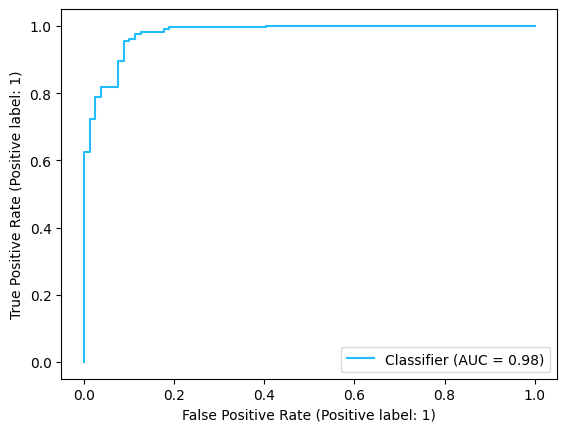

In [76]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

# Inference(XLNet)


In [5]:
test_df = pd.read_csv('Real_case_inference0319.csv', encoding= 'unicode_escape')
print(f'Total shape : {test_df.shape}')

Total shape : (4, 4)


In [6]:
test_sentences = test_df.tweet.values

test_labels = test_df.ground_truth.values
#print(test_sentences)

In [7]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

In [8]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [9]:
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))
test_labels = torch.tensor(test_labels)

In [10]:
batch_size = 1

test_data = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [11]:
# 載入XLNet模型
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))
model.to(device)
model.eval()

# 預測
preds = []
labels_list = []
probs_list = []  # 用於存儲正類概率

for batch in test_dataloader:
    input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds_batch = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        # 從logits取得正類的概率
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pos_probs_batch = probs[:, 1].cpu().numpy()
        
    preds.append(preds_batch)
    labels_list.append(labels_batch.cpu().numpy())
    probs_list.append(pos_probs_batch)

preds = np.concatenate(preds)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(probs_list)

# 計算準確度
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
# 使用正類的概率計算AUC
test_auc = roc_auc_score(labels, pos_probs)

print(f"XLNet Test Accuracy: {accuracy * 100:.2f}%")
print(f"XLNet Test Precision: {precision * 100:.2f}%")
print(f"XLNet Test Recall: {recall * 100:.2f}%")
print(f"XLNet Test F1-score: {f1 * 100:.2f}%")
print(f"XLNet Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNet Test Accuracy: 75.00%
XLNet Test Precision: 66.67%
XLNet Test Recall: 100.00%
XLNet Test F1-score: 80.00%
XLNet Test AUC: 100.00%


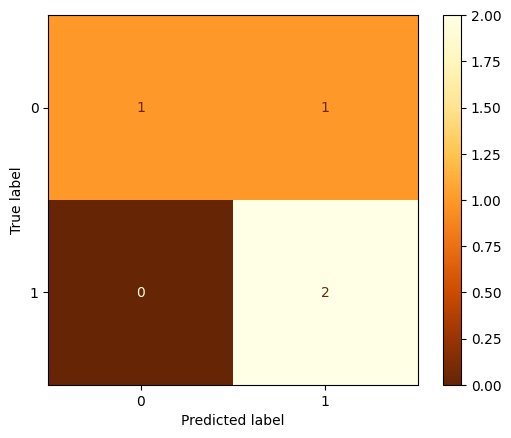

In [12]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [13]:
preds

array([1, 0, 1, 1])

In [2]:
!nvidia-smi

Mon Dec 11 11:43:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:65:00.0 Off |                  Off |
| 30%   35C    P8              18W / 230W |  22490MiB / 24564MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--